## Polinomio auto regressivo
Se tem np polos, significa que precisa de np pontos anteriores.\
O $z^{-d}$ é o atraso de transporte \
Função custo possível:
$$J = MSE+\lambda\sum numero de parametros$$
## Estimador de Markov
Estimador dos minimos quadrados ponderados
$$J=[Y - \Phi\hat{\Theta}]^TW[Y - \Phi\hat{\Theta}]$$

```py
import numpy as np
import seaborn as sb
y = np.arange(100)[::-1]+np.random.normal(size=100)
u = y*-1+np.random.normal(size=100)
n = 2

amostras = len(y)
Phi = np.column_stack((y[n-2:amostras-2],y[n-1:amostras-1],y[n:],u[n-2:amostras-2],u[n-1:amostras-1],u[n:]))
Phi.shape
theta = np.linalg.inv(Phi.T.dot(Phi)).dot(Phi.T).dot(y[n:])
y_hat = np.sum(Phi*theta.T,axis=1)
np.sum((y_hat-y[n:])**2)

def lsqrt_memoria(n, u, y):
    amostras = len(u)
    M = np.column_stack((y[n-2:amostras-2],y[n-1:amostras-1],y[n:],u[n-2:amostras-2],u[n-1:amostras-1],u[n:]))
    y = np.array(y)
    theta = np.linalg.inv(M.T.dot(M)).dot(M.T).dot(y[n:])
    y_hat = np.sum(M*theta.T,axis=1)
    return y_hat

y_hat = lsqrt_memoria(2,u,y)
np.sum((y[n:]-y_hat)**2)
```

In [112]:
# Estimador dos mínimos quadrados não-recursivo (em batelada)
# Processo de segunda ordem (2 pólos e 2 zeros)
#Bibliotecas usadas
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb

#Importa um arquivo com os dados de saída
with open('data/dryer.csv','r') as f:
    data = np.loadtxt(f,delimiter=';')
    # data = data[10:]

print('Método dos mínimos quadrados em batelada')
u = data[:,0] # Como os dados são sequênciais, é gerado uma sequência de números
y = data[:,1] # Salva os dados de saídas
print(f'Número de pontos: {u.size}')

Método dos mínimos quadrados em batelada
Número de pontos: 1000


In [113]:
def gerar_phi(na, nb, u, y, delay=1):
    numparametros = na+nb
    npts = u.size
    phi = np.ones([npts, numparametros]) # Inicia a matriz Phi para 4 parametros

    for j in range(npts): # Loop para preencher a matriz Phi
        new_phi = []
        for i in range(1,na+1):
            new_phi.append(-y[max(j-i,0)])
        for i in range(delay,nb+delay):
            new_phi.append(u[max(j-i,0)])
        phi[j] = new_phi

    return phi

In [114]:
def gerar_coeficientes(na, nb, u, y, delay=1):
    phi = gerar_phi(na, nb, u, y, delay)
    
    theta = np.linalg.inv(phi.T.dot(phi)).dot(phi.T).dot(y) # Calcula os parametros através de operações matriciais
    return theta

In [115]:
def gerar_index_phi(na, nb, size, delay):
    numparametros = na+nb
    npts = size
    index_phi = np.ones([npts, numparametros]) # Inicia a matriz Phi para 4 parametros

    for t in range(npts): # Loop para preencher a matriz Phi
        new_phi = []
        for i in range(1,na+1):
            new_phi.append(max(t-i,0))
        for i in range(delay,nb+delay):
            new_phi.append(max(t-i,0))
        index_phi[t] = new_phi

    return index_phi

In [116]:
def gerar_yest_n(na, nb, u, y, theta, delay=0):
    # Inicia a matriz de valores n passos a frente para ser preenchida]
    numparametros = na+nb
    npts = u.size
    yest_n = np.ones(npts)*y[0]

    # A partir do n ponto, calcula o valor da saída conforme os parametros estimados
    yest_u_z = np.ones(numparametros)
    for t in range(npts):
        for i in range(na):
            yest_u_z[i] = -yest_n[max(t-i-1,0)]

        for i in range(nb):
            yest_u_z[i+na] = u[max(t-i-delay,0)]

        yest_n[t] = np.sum(theta*yest_u_z)
    return yest_n

In [117]:
def gerar_yest_1(na, nb, u, y, theta, delay=0):
    # Inicia a matriz de valores n passos a frente para ser preenchida
    numparametros = na+nb
    npts = u.size
    yest_1 = np.ones(npts)*y[0]

    # A partir do n ponto, calcula o valor da saída conforme os parametros estimados
    yest_u_z = np.ones(numparametros)

    for t in range(npts):
        for i in range(na):
            yest_u_z[i] = -y[max(t-i-1,0)]

        for i in range(nb):
            yest_u_z[i+na] = u[max(t-i-delay,0)]

        # Previsão de um passo a frente
        yest_1[t] = np.sum(theta*yest_u_z)
    return yest_1

na = 3
nb = 3
theta = gerar_coeficientes(na, nb, u, y, delay=0)
yest_1 = gerar_yest_1(na, nb, u, y, theta, delay=0)

In [118]:
def gerar_dados(na, nb, u, y, delay=1):
    theta = gerar_coeficientes(na, nb, u, y, delay)
    yest_n = gerar_yest_n(na, nb, u, y, theta, delay)
    yest_1 = gerar_yest_1(na, nb, u, y, theta, delay)
    return yest_1, yest_n

In [119]:
def gerar_mse(na, nb, u, y, delay):
    yest_1, yest_n = gerar_dados(na, nb, u, y, delay)
    deep = max(na, nb)
    npts = u.size

    MSE_1 = np.sum((y-yest_1)**2)/(npts-deep)
    MSE_n = np.sum((y-yest_n)**2)/(npts-deep)
    return MSE_1, MSE_n

def comparar_mse(rna, rnb, delay):
    min_MSE = 10000
    for na in range(1,rnb+1):
        for nb in range(1,rna+1):
            MSE_1, MSE_n = gerar_mse(na, nb, u, y, delay)
            if MSE_n >= 9999:
                MSE_n = np.inf
            
            if min_MSE > MSE_1:
                min_MSE = MSE_1
                ns = (na,nb)
            theta = gerar_coeficientes(na, nb, u, y, delay)
            theta = "\t".join(map(lambda x: f'{x:0.5}',theta))
            print(f'na-nb:{na}-{nb}')
            print(f'MSE 1:\t{MSE_1:0.6f}')
            print(f'Theta:\t{theta}')
            #print(f'MSE n: {MSE_n:0.6f}')
    return 

    print(ns)
    print(min_MSE)
comparar_mse(3,3,0)

na-nb:1-1
MSE 1:	0.038606
Theta:	-0.97525	0.023932
na-nb:1-2
MSE 1:	0.036329
Theta:	-0.96153	-0.002937	0.040528
na-nb:1-3
MSE 1:	0.030050
Theta:	-0.93703	-0.0039294	-0.002009	0.067771
na-nb:2-1
MSE 1:	0.012864
Theta:	-1.7786	0.80212	0.022151
na-nb:2-2
MSE 1:	0.011625
Theta:	-1.7541	0.7878	0.0024581	0.029751
na-nb:2-3
MSE 1:	0.009060
Theta:	-1.6891	0.73903	0.0014786	0.0027549	0.044074
na-nb:3-1
MSE 1:	0.009809
Theta:	-2.1672	1.6581	-0.47459	0.015493
na-nb:3-2
MSE 1:	0.009069
Theta:	-2.1191	1.5829	-0.4391	0.00061275	0.023233
na-nb:3-3
MSE 1:	0.007392
Theta:	-2.0015	1.4033	-0.36218	0.0001274	0.0020862	0.036388
(3, 3)
0.007392073080480851


MSE 1: 0.01
MSE n: 0.04


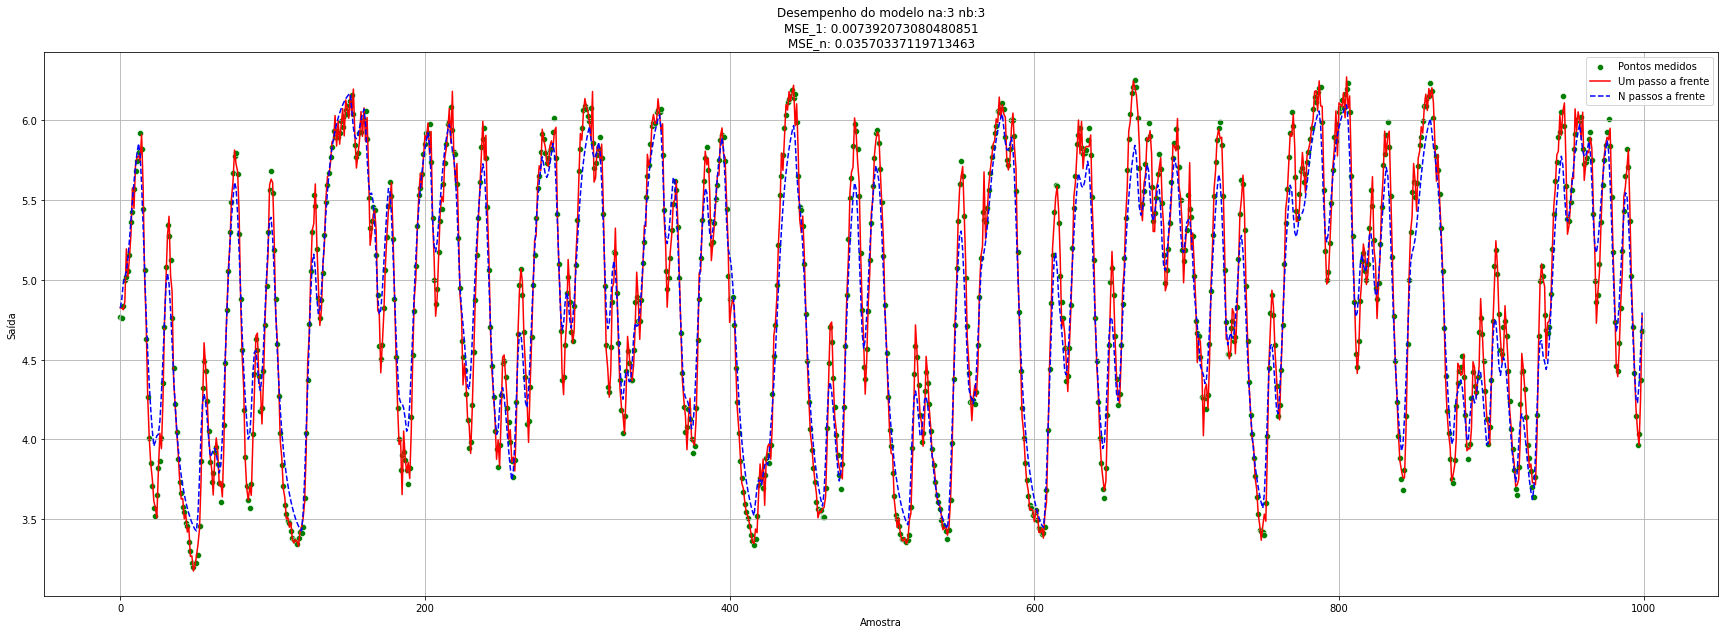

In [120]:
na, nb = 3, 3
delay = 0
yest_1, yest_n = gerar_dados(na, nb, u, y, delay)
deep = max(na, nb)
npts = u.size
yest_n[yest_n > yest_1.max()*1.5] = yest_1.max()*1.5
yest_n[yest_n < min(yest_1.min()*1.5,0)] = min(yest_1.min()*1.5,0)
# Mean Squared Error (MSE) – objetivo é um menor MSE
MSE_1 = np.sum((y-yest_1)**2)/(npts-deep)
MSE_n = np.sum((y-yest_n)**2)/(npts-deep)

print(f'MSE 1: {MSE_1:0.2f}')
print(f'MSE n: {MSE_n:0.2f}')
t = np.arange(y.size)
# Plota a figura
plt.figure(figsize = (30,10))
sb.scatterplot(x=t,y=y,color='green',markers='.',label='Pontos medidos')
#sb.barplot(x=t,y=np.abs(y-yest_1),color='purple')
sb.lineplot(x=t,y=yest_1,color='red',linestyle='-',label='Um passo a frente')
sb.lineplot(x=t,y=yest_n,color='blue',linestyle='--',label='N passos a frente')
plt.title(f'Desempenho do modelo na:{na} nb:{nb}\nMSE_1: {MSE_1}\nMSE_n: {MSE_n}')
#plt.legend(labels=["Real","Um passo a frente","N passos a frente"])
plt.xlabel('Amostra')
plt.ylabel('Saída')
plt.grid()
plt.show()
plt.close()
